In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
last_date[0][0]

'2017-08-23'

In [11]:
# Calculate the date one year from the last date in data set.
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

In [12]:
# Perform a query to retrieve the data and precipitation scores
precipitation_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])


In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df.set_index('date', inplace = True)
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [14]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by = 'date')
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


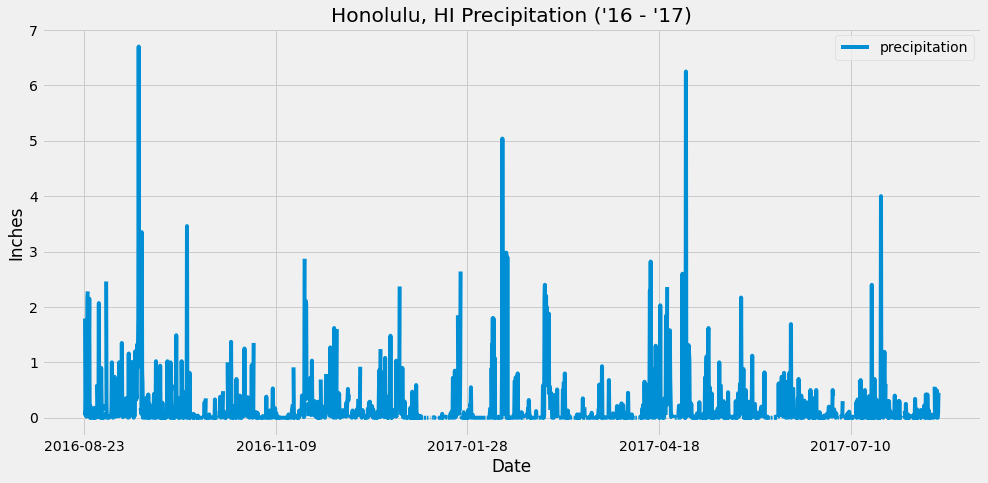

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
fig, ax = plt.subplots(figsize = (15, 7))
precipitation_df.plot(ax = ax, x_compat = True)

#Create labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
ax.set_title("Honolulu, HI Precipitation ('16 - '17)")

# save plot
plt.savefig("Images/precipitation.png")

# display plot
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_num = session.query(Station.id).distinct().count()
station_num

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_rows = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_rows:
    print(f"{result[0]}\tCount: {result[1]}")

USC00519281	Count: 2772
USC00519397	Count: 2724
USC00513117	Count: 2709
USC00519523	Count: 2669
USC00516128	Count: 2612
USC00514830	Count: 2202
USC00511918	Count: 1979
USC00517948	Count: 1372
USC00518838	Count: 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = 'USC00519281'
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
print(f"Lowest Temperature: {most_active_temps[0][0]} Fahrenheit, Highest Temperature: {most_active_temps[0][1]} Fahrenheit, Average Temperature: {round(most_active_temps[0][2], 2)} Fahrenheit  ")

Lowest Temperature: 54.0 Fahrenheit, Highest Temperature: 85.0 Fahrenheit, Average Temperature: 71.66 Fahrenheit  


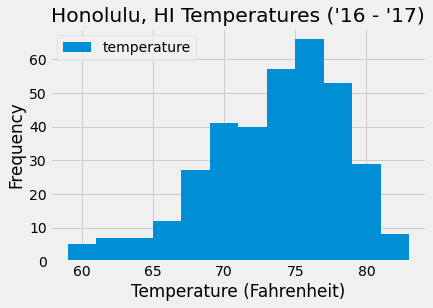

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# Save as a data frame
year_temps_df = pd.DataFrame(year_temps, columns = ['date', 'temperature'])

# Set index by date
year_temps_df.set_index('date', inplace = True)

fig, ax = plt.subplots()
year_temps_df.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Honolulu, HI Temperatures ('16 - '17)")

#save figure
plt.savefig("Images/temperature_history.png")

#plot

plt.show()

# Close session

In [21]:
# Close Session
session.close()